In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential,Model
from keras.layers import Activation
from keras.layers.core import Dense,Flatten,Dropout
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
import keras 
import keras.backend as B
import numpy as np
import keras.applications as A
import matplotlib.pyplot as plt
%matplotlib inline

import os
from keras import regularizers

In [2]:
train_path = "../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN"
test_path = "../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN"

In [3]:
inputs = (240,320,3)

In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224),classes=['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'],batch_size=50)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224),classes=['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'],batch_size=50)

Found 9957 images belonging to 4 classes.
Found 9957 images belonging to 4 classes.


In [5]:
vgg = A.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=inputs)
#vgg.summary()

2022-11-09 04:16:51.654137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 04:16:51.746826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 04:16:51.747607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 04:16:51.749405: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [6]:
model = Sequential()
for layer in vgg.layers[:-4]:
  layer.trainable=False

In [7]:
for layer in vgg.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff522f83350> False
<keras.layers.convolutional.Conv2D object at 0x7ff51bcc7790> False
<keras.layers.convolutional.Conv2D object at 0x7ff520dc5190> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff580ec3a10> False
<keras.layers.convolutional.Conv2D object at 0x7ff520bfedd0> False
<keras.layers.convolutional.Conv2D object at 0x7ff51bf64d10> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff51bf73d90> False
<keras.layers.convolutional.Conv2D object at 0x7ff51bf73f50> False
<keras.layers.convolutional.Conv2D object at 0x7ff51bf694d0> False
<keras.layers.convolutional.Conv2D object at 0x7ff51bf7d790> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff51bf0a990> False
<keras.layers.convolutional.Conv2D object at 0x7ff51bf06f90> False
<keras.layers.convolutional.Conv2D object at 0x7ff51bf7d190> False
<keras.layers.convolutional.Conv2D object at 0x7ff51bf1a0d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff51bf1a610>

In [8]:
# Add the vgg convolutional base model
model.add(vgg)
 
# Add new layers
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 10, 512)        14714688  
_________________________________________________________________
flatten (Flatten)            (None, 35840)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 35840)             143360    
_________________________________________________________________
dense (Dense)                (None, 32)                1146912   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5

In [9]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest', validation_split=0.25)


validation_datagen = ImageDataGenerator(rescale=1./255 )
 
# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20

In [10]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(240, 320),
        batch_size=train_batchsize,
        class_mode='categorical', subset = "training")
 
validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(240, 320),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False,
    subset='validation')

Found 7470 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size,
      verbose=1)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-09 04:16:58.009121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-09 04:17:00.563787: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


373/373 [==============================] - 214s 547ms/step - loss: 1.5322 - acc: 0.3079 - val_loss: 1.3831 - val_acc: 0.3129
Epoch 2/10
373/373 [==============================] - 182s 487ms/step - loss: 1.3097 - acc: 0.4064 - val_loss: 1.1823 - val_acc: 0.4452
Epoch 3/10
373/373 [==============================] - 181s 486ms/step - loss: 1.1798 - acc: 0.4729 - val_loss: 1.0733 - val_acc: 0.5492
Epoch 4/10
373/373 [==============================] - 185s 495ms/step - loss: 1.0548 - acc: 0.5519 - val_loss: 1.3761 - val_acc: 0.4746
Epoch 5/10
373/373 [==============================] - 181s 486ms/step - loss: 0.9368 - acc: 0.6149 - val_loss: 0.7764 - val_acc: 0.7613
Epoch 6/10
373/373 [==============================] - 181s 484ms/step - loss: 0.8470 - acc: 0.6799 - val_loss: 0.5790 - val_acc: 0.8077
Epoch 7/10
373/373 [==============================] - 183s 490ms/step - loss: 0.7901 - acc: 0.7243 - val_loss: 0.6727 - val_acc: 0.7242
Epoch 8/10
373/373 [==============================] - 183s 

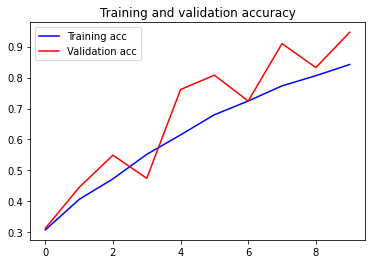

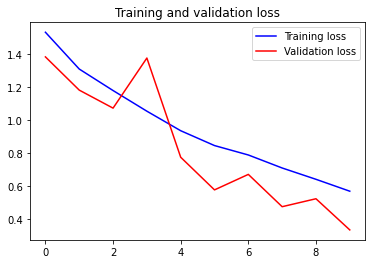

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()